# **Factors Influencing High-Sale Products**

# Data Preprocessing

## Loading Libraries

In [75]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

## Loading Dataset

In [27]:
df = pd.read_csv("retail_sales_dataset.csv")
df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


## Categorical Variable Encoding

In [28]:
# Encoding the Sex column into numeric values (0,1)
df["Gender"] = df["Gender"].map({"Male": 0, "Female": 1})


## Deleting the Unnecessary Data

In [29]:
df.drop(columns=["Transaction ID"],inplace=True)

## Missing values

In [30]:
# Checking for missing values in dataset
df.isnull().sum()

Date                0
Customer ID         0
Gender              0
Age                 0
Product Category    0
Quantity            0
Price per Unit      0
Total Amount        0
dtype: int64

## Correction of data types and date column


In [31]:
df["Date"] = pd.to_datetime(df["Date"])
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df.head()

,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount,Month,Day
0,2023-11-24,CUST001,0,34,Beauty,3,50,150,11,24
1,2023-02-27,CUST002,1,26,Clothing,2,500,1000,2,27
2,2023-01-13,CUST003,0,50,Electronics,1,30,30,1,13
3,2023-05-21,CUST004,0,37,Clothing,1,500,500,5,21
4,2023-05-06,CUST005,0,30,Beauty,2,50,100,5,6


In [32]:
df.drop(columns=["Date"], inplace=True)


In [33]:
df[["Quantity", "Price per Unit", "Total Amount"]].describe()


,Quantity,Price per Unit,Total Amount
count,1000.000000,1000.000000,1000.000000
mean,2.514000,179.890000,456.000000
std,1.132734,189.681356,559.997632
min,1.000000,25.000000,25.000000
25%,1.000000,30.000000,60.000000
50%,3.000000,50.000000,135.000000
75%,4.000000,300.000000,900.000000
max,4.000000,500.000000,2000.000000


## Total sales by product category


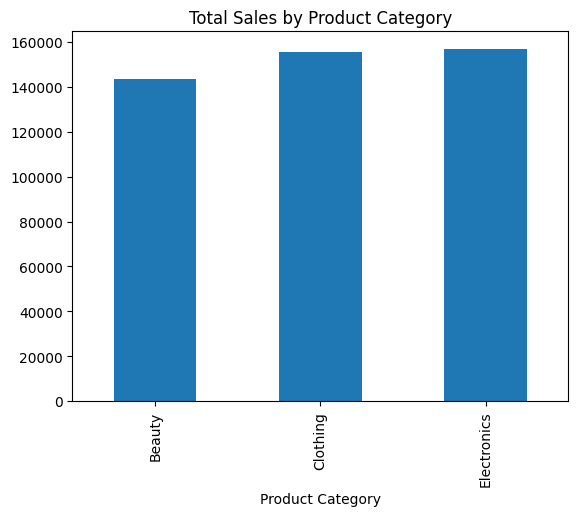

In [50]:
df.groupby("Product Category")["Total Amount"].sum().plot(kind="bar")
plt.title("Total Sales by Product Category")
plt.show()

From this plot, we can see that the best-selling products belong to Electronics, Clothing, and Beauty, in that order, but the difference between these three is small.


## Average purchase by age
ُ

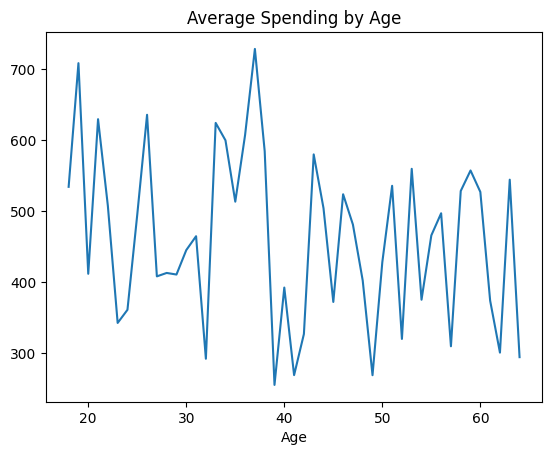

In [51]:
df.groupby("Age")["Total Amount"].mean().plot()
plt.title("Average Spending by Age")
plt.show()

* Spending peaks in early middle age (around 35–40 years).
* Youth and old age are associated with lower spending and greater variability.
* This pattern aligns with the Life-Cycle Hypothesis: people spend less in youth and old age and more in middle age (when income is at its peak).

In [69]:
# Average
category_mean = df.groupby("Product Category")["Total Amount"].mean()

df["High_Sale"] = df["Product Category"].map(
    lambda x: 1 if category_mean[x] >= category_mean.mean() else 0
)


In [72]:
X = df[["Gender", "Age", "Quantity", "Price per Unit", "Month", "Day"]]
y = df["High_Sale"]

In [76]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.32      0.31        60
           1       0.70      0.68      0.69       140

    accuracy                           0.57       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.58      0.57      0.57       200



* Precision  → Of the times the model predicted "best-selling," how many were actually correct.
* Recall  → Of all the actual best-selling items, how many did the model correctly identify.
* F1-score → The harmonic mean of Precision and Recall.
* The model correctly predicted 57% of the time.
* The model performs well in detecting high-selling items (F1 ≈ 0.69).
* The model performs poorly in detecting low-selling items (F1 ≈ 0.31).



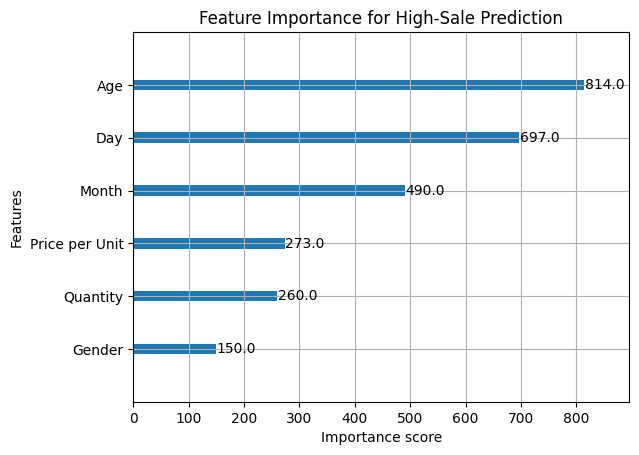

In [68]:
xgb.plot_importance(model)
plt.title("Feature Importance for High-Sale Prediction")
plt.show()

**Feature Ranking by Importance:**

* Age: 814.0 → Most important
* Day: 697.0 → Second key factor
* Month: 490.0 → Moderate impact
* Price per Unit: 273.0 → Low impact
* Quantity: 260.0 → Low impact
* Gender: 150.0 → Least important

* (Age, Day, Month) drive high-sale predictions.
* Price and quantity have limited influence.
* Gender is nearly irrelevant.

* We should focus on customer age and purchase timing (day & month)